In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.cluster
import umap
import pandas as pd

import warnings
warnings.filterwarnings('ignore') # Omitir los warnings

## Popularidad de páginas web de noticias

Este es un set de datos que busca asociar la popularidad de páginas de noticias (medida en 'shares' en redes sociales) a la frecuencia de ciertos tipos de contenidos. Para facilidad de visualización, el target se establece como el cuartil de popularidad en el que está la página.

In [2]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data = data.drop(['url'],axis=1)
Y = np.array(data[' shares'])
data = data.drop([' shares'],axis=1)
X = np.array(data)

In [3]:
np.shape(X)
indices = np.arange(len(Y))
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]
X = X[:4000] # Coge un subconjunto aleatorio de los datos para que alcance a correr :/
Y = Y[:4000]

sorteado = np.sort(Y)
q1,q2,q3=sorteado[int(len(Y)/4)],sorteado[2*int(len(Y)/4)],sorteado[3*int(len(Y)/4)]

Y = 1*(Y>q1)+1*(Y>q2)+1*(Y>q3) #Dividir el target en cuartiles
np.shape(X)

(4000, 59)

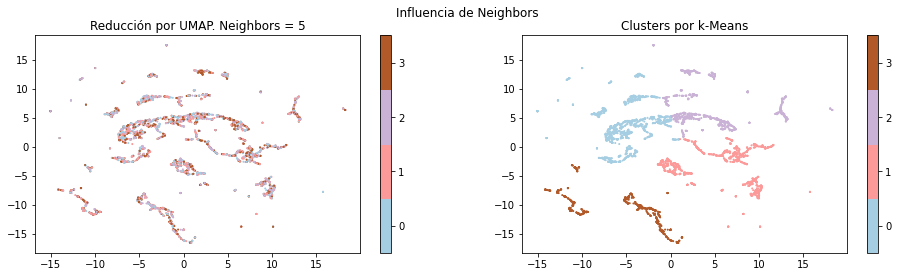

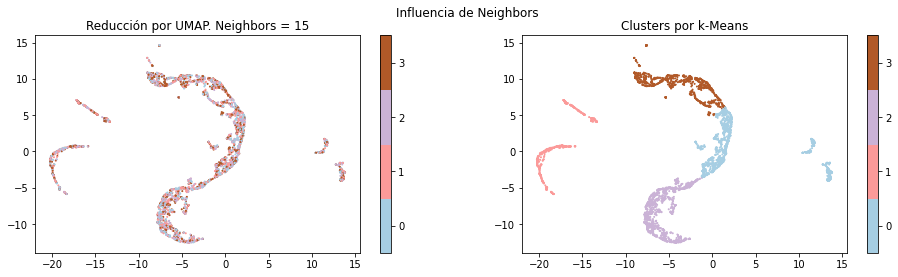

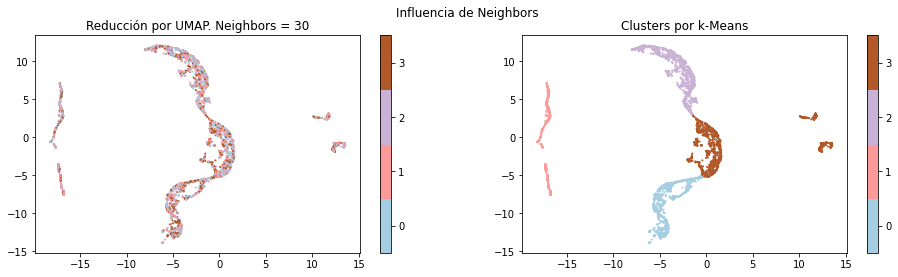

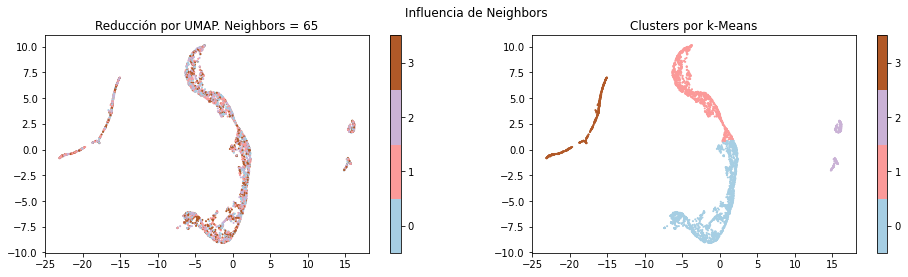

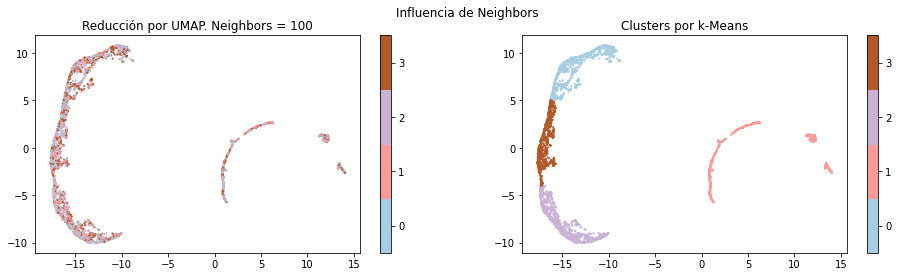

In [4]:
for n in [5,15,30,65,100]:
    reducer = umap.UMAP(n_neighbors=n)
    reducer.fit(X)
    
    embedding = reducer.transform(X)
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.scatter(embedding[:,0], embedding[:,1], c=Y, cmap='Paired', s=1.0)
    plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
    plt.title('Reducción por UMAP. Neighbors = ' + str(n))
    
    n_clusters = 4
    k_means = sklearn.cluster.KMeans(n_clusters=n_clusters)
    k_means.fit(embedding) # training
    cluster = k_means.predict(embedding) # predice a cual cluster corresponde cada elmento
    distance = k_means.transform(embedding) # calcula la distancia de cada elemento al centro de su cluster
    
    plt.subplot(122)
    plt.scatter(embedding[:,0], embedding[:,1], c=cluster, cmap='Paired', s=1.0)
    plt.colorbar(boundaries=np.arange(n_clusters+1)-0.5).set_ticks(np.arange(n_clusters))
    plt.title('Clusters por k-Means')
    
    plt.suptitle('Influencia de Neighbors')

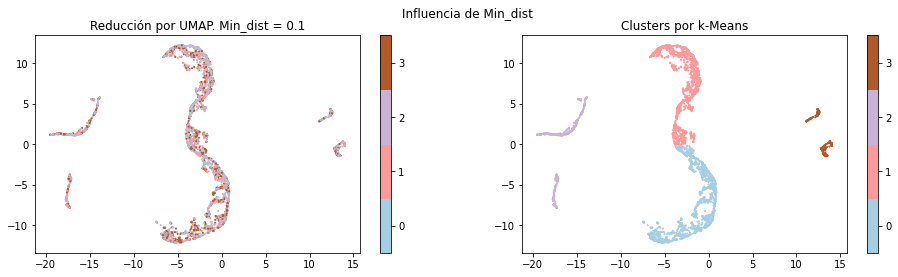

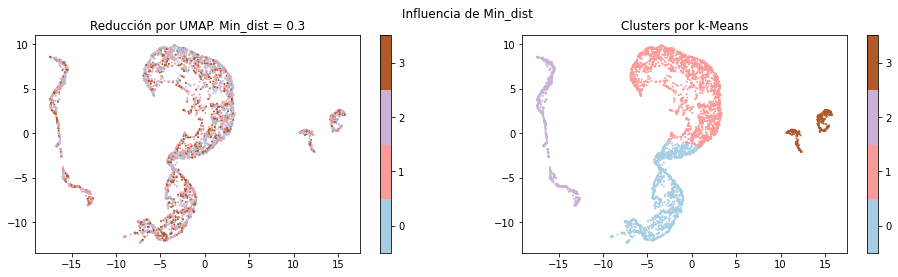

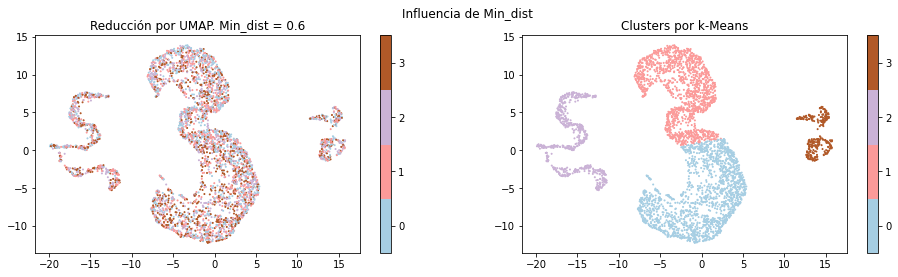

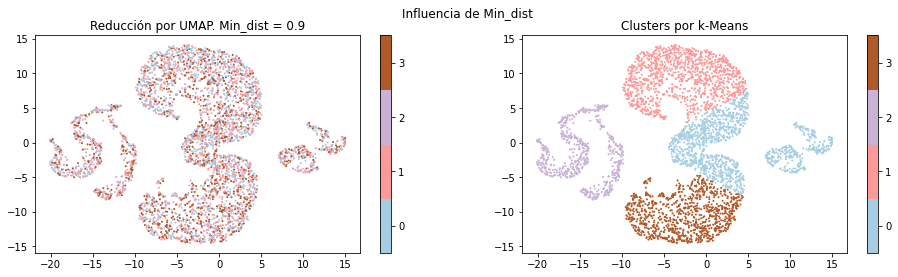

In [5]:
for dist in [0.1,0.3,0.6,0.9]:
    reducer = umap.UMAP(n_neighbors=25,min_dist=dist)
    reducer.fit(X)

    embedding = reducer.transform(X)
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.scatter(embedding[:,0], embedding[:,1], c=Y, cmap='Paired', s=1.0)
    plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
    plt.title('Reducción por UMAP. Min_dist = ' + str(dist))
    
    n_clusters = 4
    k_means = sklearn.cluster.KMeans(n_clusters=n_clusters)
    k_means.fit(embedding) # training
    cluster = k_means.predict(embedding) # predice a cual cluster corresponde cada elmento
    distance = k_means.transform(embedding) # calcula la distancia de cada elemento al centro de su cluster
    
    plt.subplot(122)
    plt.scatter(embedding[:,0], embedding[:,1], c=cluster, cmap='Paired', s=1.0)
    plt.colorbar(boundaries=np.arange(n_clusters+1)-0.5).set_ticks(np.arange(n_clusters))
    plt.title('Clusters por k-Means')
    
    plt.suptitle('Influencia de Min_dist')

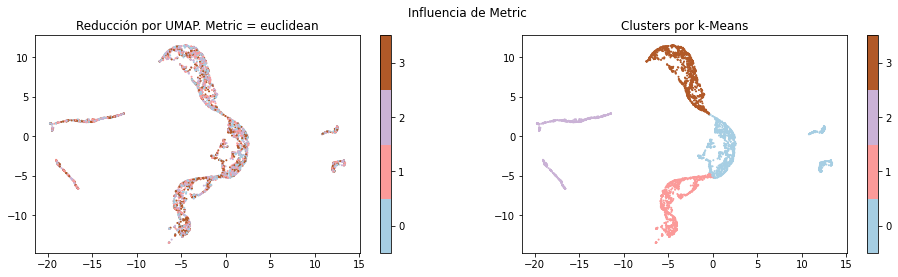

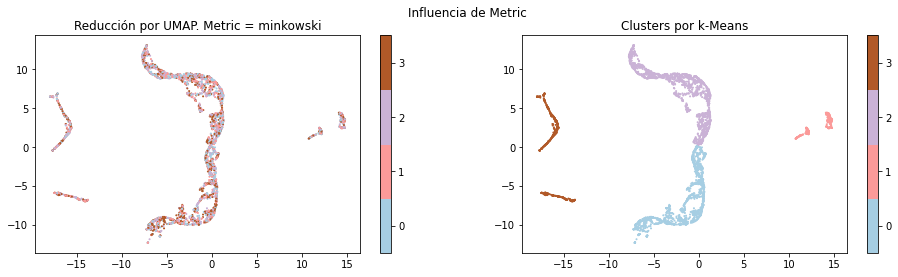

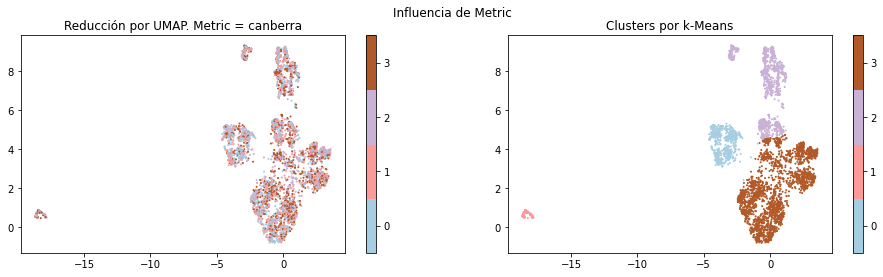

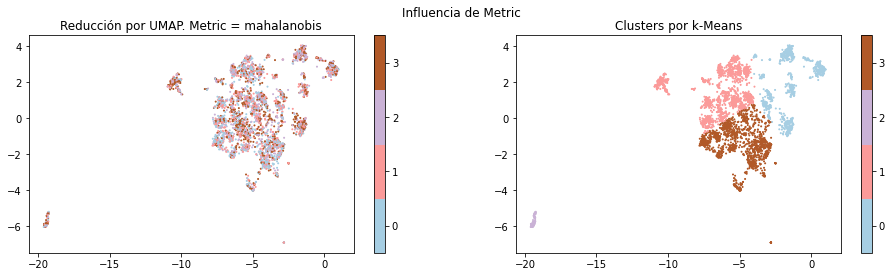

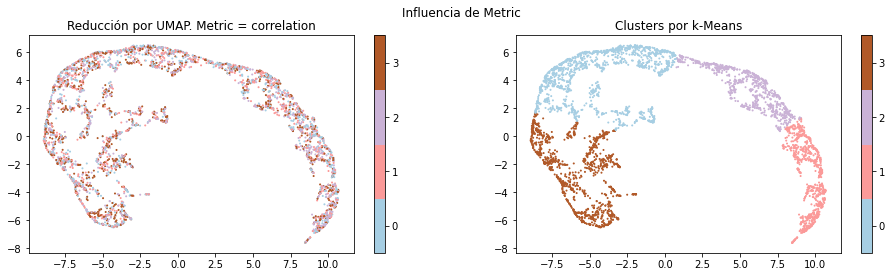

In [6]:
for met in ('euclidean','minkowski','canberra','mahalanobis','correlation'):
    reducer = umap.UMAP(n_neighbors=25,metric=met)
    reducer.fit(X)

    embedding = reducer.transform(X)
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.scatter(embedding[:,0], embedding[:,1], c=Y, cmap='Paired', s=1.0)
    plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
    plt.title('Reducción por UMAP. Metric = ' + met)
    
    n_clusters = 4
    k_means = sklearn.cluster.KMeans(n_clusters=n_clusters)
    k_means.fit(embedding) # training
    cluster = k_means.predict(embedding) # predice a cual cluster corresponde cada elmento
    distance = k_means.transform(embedding) # calcula la distancia de cada elemento al centro de su cluster
    
    plt.subplot(122)
    plt.scatter(embedding[:,0], embedding[:,1], c=cluster, cmap='Paired', s=1.0)
    plt.colorbar(boundaries=np.arange(n_clusters+1)-0.5).set_ticks(np.arange(n_clusters))
    plt.title('Clusters por k-Means')
    
    plt.suptitle('Influencia de Metric')

## Discusión de resultados

De las gráficas obtenidas para cada juego de parámetros, se puede observar que, en general, tienden a armarse 3 regiones donde se agrupan los datos: una región elongada en forma de creciente que contiene la mayor parte de los datos, una región en forma de cuña, y un grupo de islas separado muy lejano a las otras dos regiones que contiene una porción muy pequeña de los datos. Si bien las regiones son visualmente claras, no tienden a formar cúmulos condensados, por lo cual el método de k-means no tiende a separarlas precisamente entre las regiones evidenciadas.

Cabe mencionar que los clusters observados no parecen llevar relación con el target; lo más seguro es que representen grupos de 'estrategias' de administración de páginas web, caso en el cual habría una estrategia muy común correspondiente a la región más poblada, una estrategia menos convencional pero aún popular, y un grupo de estrategias no-convencionales.

## Influencia de los parámetros

El parámetro de `neighbors` establece el tamaño de los grupos que analiza UMAP, y así determina que tan global o local será el comportamiento de los datos que se proyecta en el espacio reducido. En este caso, este parámetro no parece haber incidido demasiado, viendo que el único cambio importante se dio cuando se establecio 5 neighbors. de resto, para todos los otros valores de este parámetro la tendencia observada fue la misma.

El parámetro de `min_dist` establece la distancia mínima permitida entre los datos, de manera que afecta la densidad de las agrupaciones de los datos en el espacio reducido. Esta tendencia se observó claramente en las gráficas correspondientes, pero conservó la manera general en que se agrupaban los datos.

El parámetro de `metric` decide qué metrica se usará para medir las distancias entre datos. La metrica de minkowski presentó un comportamiento muy similar a la euclidiana, dando lugar a las mismas regiones de datos. Las otras metricas sí afectaron considerablemente el comportamiento observado: la de canberra y la de mahalanobis generaron clusters concentrados de datos, mientras que la de correlación ubicó los datos sobre una parábola.